## install pysgmcmc

In [ ]:
!pip install git+https://github.com/MFreidank/pysgmcmc
import os
os.kill(os.getpid(), 9)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/MFreidank/pysgmcmc to /tmp/pip-req-build-zxherv5e
  Running command git clone --filter=blob:none --quiet https://github.com/MFreidank/pysgmcmc /tmp/pip-req-build-zxherv5e
  Resolved https://github.com/MFreidank/pysgmcmc to commit 1fe63570486e2d3f6cc2d3016314a92b96464b00
  Preparing metadata (setup.py) ... done


## import and data

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np
import matplotlib.pyplot as plt

import torch.optim as optim

import torch.nn as nn
import torch.nn.functional as F

In [2]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 16

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 78863153.09it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [4]:
# code retrieved from https://pysgmcmc.readthedocs.io/en/pytorch/_modules/pysgmcmc/optimizers/sgld.html

import torch
from torch.optim import Optimizer


# Pytorch Port of a previous tensorflow implementation in `tensorflow_probability`:
# https://github.com/tensorflow/probability/blob/master/tensorflow_probability/g3doc/api_docs/python/tfp/optimizer/StochasticGradientLangevinDynamics.md
class SGLD(Optimizer):
    """ Stochastic Gradient Langevin Dynamics Sampler with preconditioning.
        Optimization variable is viewed as a posterior sample under Stochastic
        Gradient Langevin Dynamics with noise rescaled in eaach dimension
        according to RMSProp.
    """
    def __init__(self,
                 params,
                 lr=1e-2,
                 precondition_decay_rate=0.95,
                 num_pseudo_batches=1,
                 num_burn_in_steps=3000,
                 diagonal_bias=1e-8) -> None:
        """ Set up a SGLD Optimizer.

        Parameters
        ----------
        params : iterable
            Parameters serving as optimization variable.
        lr : float, optional
            Base learning rate for this optimizer.
            Must be tuned to the specific function being minimized.
            Default: `1e-2`.
        precondition_decay_rate : float, optional
            Exponential decay rate of the rescaling of the preconditioner (RMSprop).
            Should be smaller than but nearly `1` to approximate sampling from the posterior.
            Default: `0.95`
        num_pseudo_batches : int, optional
            Effective number of minibatches in the data set.
            Trades off noise and prior with the SGD likelihood term.
            Note: Assumes loss is taken as mean over a minibatch.
            Otherwise, if the sum was taken, divide this number by the batch size.
            Default: `1`.
        num_burn_in_steps : int, optional
            Number of iterations to collect gradient statistics to update the
            preconditioner before starting to draw noisy samples.
            Default: `3000`.
        diagonal_bias : float, optional
            Term added to the diagonal of the preconditioner to prevent it from
            degenerating.
            Default: `1e-8`.

        """
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if num_burn_in_steps < 0:
            raise ValueError("Invalid num_burn_in_steps: {}".format(num_burn_in_steps))

        defaults = dict(
            lr=lr, precondition_decay_rate=precondition_decay_rate,
            num_pseudo_batches=num_pseudo_batches,
            num_burn_in_steps=num_burn_in_steps,
            diagonal_bias=1e-8,
        )
        super().__init__(params, defaults)


    def step(self, closure=None):
        loss = None

        if closure is not None:
            loss = closure()

        for group in self.param_groups:
            for parameter in group["params"]:

                if parameter.grad is None:
                    continue

                state = self.state[parameter]
                lr = group["lr"]
                num_pseudo_batches = group["num_pseudo_batches"]
                precondition_decay_rate = group["precondition_decay_rate"]
                gradient = parameter.grad.data

                #  State initialization {{{ #

                if len(state) == 0:
                    state["iteration"] = 0
                    state["momentum"] = torch.ones_like(parameter)

                #  }}} State initialization #

                state["iteration"] += 1

                momentum = state["momentum"]

                #  Momentum update {{{ #
                momentum.add_(
                    (1.0 - precondition_decay_rate) * ((gradient ** 2) - momentum)
                )
                #  }}} Momentum update #

                if state["iteration"] > group["num_burn_in_steps"]:
                    sigma = 1. / torch.sqrt(torch.tensor(lr))
                else:
                    sigma = torch.zeros_like(parameter)

                preconditioner = (
                    1. / torch.sqrt(momentum + group["diagonal_bias"])
                )

                scaled_grad = (
                    0.5 * preconditioner * gradient * num_pseudo_batches +
                    torch.normal(
                        mean=torch.zeros_like(gradient),
                        std=torch.ones_like(gradient)
                    ) * sigma * torch.sqrt(preconditioner)
                )

                parameter.data.add_(-lr * scaled_grad)

        return loss

## base model: ResNet

In [5]:
# https://niko-gamulin.medium.com/resnet-implementation-with-pytorch-from-scratch-23cf3047cb93
class Block(nn.Module):
    def __init__(self, num_layers, in_channels, out_channels, identity_downsample=None, stride=1):
        assert num_layers in [18, 34, 50, 101, 152], "should be a a valid architecture"
        super(Block, self).__init__()
        self.num_layers = num_layers
        if self.num_layers > 34:
            self.expansion = 4
        else:
            self.expansion = 1
        # ResNet50, 101, and 152 include additional layer of 1x1 kernels
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)
        if self.num_layers > 34:
            self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        else:
            # for ResNet18 and 34, connect input directly to (3x3) kernel (skip first (1x1))
            self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.conv3 = nn.Conv2d(out_channels, out_channels * self.expansion, kernel_size=1, stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels * self.expansion)
        self.relu = nn.ReLU()
        self.identity_downsample = identity_downsample

    def forward(self, x):
        identity = x
        if self.num_layers > 34:
            x = self.conv1(x)
            x = self.bn1(x)
            x = self.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)

        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)

        x += identity
        x = self.relu(x)
        return x

In [6]:
class ResNet(nn.Module):
    def __init__(self, num_layers, block, image_channels, num_classes):
        assert num_layers in [18, 34, 50, 101, 152], f'ResNet{num_layers}: Unknown architecture! Number of layers has ' \
                                                     f'to be 18, 34, 50, 101, or 152 '
        super(ResNet, self).__init__()
        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]
        self.in_channels = 64
        self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def partial_eval(self,x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


def ResNet18(img_channels=3, num_classes=1000):
    return ResNet(18, Block, img_channels, num_classes)


def ResNet34(img_channels=3, num_classes=1000):
    return ResNet(34, Block, img_channels, num_classes)


In [ ]:
net = ResNet18(img_channels=3, num_classes=10)
net.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, 

In [ ]:
#import pysgmcmc

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
#optimizer = SGLD(net.parameters(), lr=0.0001)

In [ ]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        '''
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
        '''
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')
    running_loss = 0.0

    correct = 0
    total = 0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()

            # calculate outputs by running images through the network
            outputs = net(images)
            # the class with the highest energy is what we choose as prediction
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print('Accuracy of the network on the test images:'+str(correct / total))
print('Finished Training')

[1,  3125] loss: 1.550
Accuracy of the network on the test images:0.5429
[2,  3125] loss: 1.151
Accuracy of the network on the test images:0.6338
[3,  3125] loss: 0.948
Accuracy of the network on the test images:0.6555
[4,  3125] loss: 0.809
Accuracy of the network on the test images:0.6766
[5,  3125] loss: 0.707
Accuracy of the network on the test images:0.702
[6,  3125] loss: 0.621
Accuracy of the network on the test images:0.7092
[7,  3125] loss: 0.545
Accuracy of the network on the test images:0.709
[8,  3125] loss: 0.473
Accuracy of the network on the test images:0.723
[9,  3125] loss: 0.412
Accuracy of the network on the test images:0.7354
[10,  3125] loss: 0.359
Accuracy of the network on the test images:0.7192
[11,  3125] loss: 0.315
Accuracy of the network on the test images:0.7209
[12,  3125] loss: 0.271
Accuracy of the network on the test images:0.7287
[13,  3125] loss: 0.242
Accuracy of the network on the test images:0.7312
[14,  3125] loss: 0.208
Accuracy of the network on

KeyboardInterrupt: ignored

In [7]:
from google.colab import drive
drive.mount('/content/drive')
!cp /content/drive/MyDrive/Res18.pth ./Res18.pth
PATH = './Res18.pth'
#projection_weight_path = './LeNet_pr.pth'
net = ResNet18(img_channels=3, num_classes=10).to(device)
net.load_state_dict(torch.load(PATH))
#net.projection = torch.load(projection_weight_path)

Mounted at /content/drive


<All keys matched successfully>

In [ ]:
PATH = './Res18.pth'
#projection_weight_path = './LeNet_pr.pth'
torch.save(net.state_dict(), PATH)
#torch.save(net.projection, projection_weight_path)

In [ ]:
PATH = './Res18.pth'
#projection_weight_path = './LeNet_pr.pth'
net = ResNet18(img_channels=3, num_classes=10).to(device)
net.load_state_dict(torch.load(PATH))
#net.projection = torch.load(projection_weight_path)

<All keys matched successfully>

In [8]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()

        # calculate outputs by running images through the network
        outputs = net(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images:'+str(correct / total))

Accuracy of the network on the test images:0.7549


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp ./Res18.pth /content/drive/MyDrive/Res18.pth

## NN decryption 2 party

In [9]:
x_t = next(iter(testloader))
x_t = x_t[0].to(device)
r = net.partial_eval(x_t)
print(r.shape)

torch.Size([16, 64, 8, 8])


In [10]:
print(x_t.shape)

torch.Size([16, 3, 32, 32])


In [11]:
class ResNet_decrypt(nn.Module):

    def __init__(self, num_layers, block, image_channels, num_classes):
        super(ResNet_decrypt, self).__init__()


        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]

        #self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        #self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # correspond to conv1
        self.in_channels = 64
        self.enc1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        # correspond to bn1
        self.enc2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.enc_layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)

        self.layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=2)
        self.layer3 = self.make_layers(num_layers, block, layers[2], intermediate_channels=256, stride=2)
        self.layer4 = self.make_layers(num_layers, block, layers[3], intermediate_channels=512, stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * self.expansion, num_classes)

    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.enc_layer1(x)
        #public
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x

    def partial_eval(self,x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.enc_layer1(x)
        return x

    def partial_out(self,x):
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)
        x = self.fc(x)
        return x
    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


net_decrypt = ResNet_decrypt(18, Block, image_channels=3, num_classes=10)

# freeze anything after layer1
net_decrypt.layer2.requires_grad_(False)
net_decrypt.layer3.requires_grad_(False)
net_decrypt.layer4.requires_grad_(False)
net_decrypt.fc.requires_grad_(False)
'''
for param in net_decrypt.parameters():
    param.requires_grad = False


for n,_ in net_decrypt.named_parameters():
  print(n)


# first 16 filters at client
counter=16
print(net_decrypt)
for c in range(counter):
'''

'''
net_decrypt.enc1.weight.requires_grad = True
net_decrypt.enc2.weight.requires_grad = True

net_decrypt.enc3.weight.requires_grad = True
net_decrypt.enc4.weight.requires_grad = True
net_decrypt.enc5.weight.requires_grad = True
net_decrypt.enc6.weight.requires_grad = True

net_decrypt.match_size.weight.requires_grad = True
net_decrypt.enc1.bias.requires_grad = True
net_decrypt.enc2.bias.requires_grad = True

net_decrypt.enc3.bias.requires_grad = True
net_decrypt.enc4.bias.requires_grad = True
net_decrypt.enc5.bias.requires_grad = True
net_decrypt.enc6.bias.requires_grad = True

net_decrypt.match_size.bias.requires_grad = True
net.enc1 = nn.Conv2d(1,6,3,padding='same')
net.enc2 = nn.Conv2d(6,16,3,padding='same')
net.enc3 = nn.Conv2d(6,16,3,padding='same')
net.enc4 = nn.Conv2d(16,1,3,padding='same')
'''
net_decrypt.to(device)

ResNet_decrypt(
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (enc2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [12]:
r_enc = net_decrypt.partial_eval(x_t)
print(r_enc.shape)

torch.Size([16, 64, 8, 8])


In [13]:
for param in net_decrypt.parameters():
  print(param.requires_grad)

True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False


In [14]:
PATH = './Res18.pth'
net_decrypt.load_state_dict(torch.load(PATH), strict=False)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net_decrypt.parameters(), lr=0.001, momentum=0.9)

train the top layers

In [15]:
# what we know: 4 layer could not adeqautely represent
# 6 layer also does not work: acc->10.88
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_decrypt(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()

        '''
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
        '''
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')
    running_loss = 0.0
print('Finished Training')

[1,  3125] loss: 2.323
[2,  3125] loss: 0.657
[3,  3125] loss: 0.386
[4,  3125] loss: 0.275
[5,  3125] loss: 0.214
[6,  3125] loss: 0.173
[7,  3125] loss: 0.141
[8,  3125] loss: 0.128
[9,  3125] loss: 0.110
[10,  3125] loss: 0.103
[11,  3125] loss: 0.093
[12,  3125] loss: 0.080
[13,  3125] loss: 0.074
[14,  3125] loss: 0.065
[15,  3125] loss: 0.062
[16,  3125] loss: 0.060
[17,  3125] loss: 0.057
[18,  3125] loss: 0.054
[19,  3125] loss: 0.051
[20,  3125] loss: 0.051
[21,  3125] loss: 0.046
[22,  3125] loss: 0.043
[23,  3125] loss: 0.040
[24,  3125] loss: 0.039
[25,  3125] loss: 0.038


KeyboardInterrupt: ignored

In [23]:
PATH = './ResNet_decrypt.pth'

torch.save(net_decrypt.state_dict(), PATH)

In [ ]:
PATH = './ResNet_decrypt.pth'

net_decrypt.load_state_dict(torch.load(PATH))

In [ ]:
PATH2 = './Res18.pth'
#projection_weight_path = './LeNet_pr.pth'
net = ResNet18(img_channels=3, num_classes=10).to(device)
net.load_state_dict(torch.load(PATH2))

<All keys matched successfully>

In [16]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        '''
        # calculate outputs by running images through the network
        intermediate = net.partial_eval(images)
        print(intermediate.shape)
        sh = images[0,:,:,:].cpu().numpy()
        sh = sh/2+0.5
        plt.imshow(np.transpose(sh, (1,2,0)))
        plt.show()
        plt.imshow(intermediate[0,1,:,:].cpu().numpy())
        break
        outputs = net_decrypt.partial_out(intermediate)
        '''
        outputs = net_decrypt(images)
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the test images:'+str(correct / total))

Accuracy of the network on the test images:0.7457


In [ ]:

!cp ./ResNet_decrypt.pth /content/drive/MyDrive/ResNet_decrypt.pth

what we know: bad performance when using CNN to simulate 1 layer of ResNet -> unknown architecture could cause significant defifference

on the other hand, if we know the architecture, we can recover the weights and use decoder to recover the image

conclusion of now: there exists "SOME" encoder-decoder group that can recover the image if the server knows the training dataset

### decoder

In [63]:
class ResNet_decoder(nn.Module):

    def __init__(self, num_layers, block, image_channels, num_classes):
        super(ResNet_decoder, self).__init__()


        if num_layers < 50:
            self.expansion = 1
        else:
            self.expansion = 4
        if num_layers == 18:
            layers = [2, 2, 2, 2]
        elif num_layers == 34 or num_layers == 50:
            layers = [3, 4, 6, 3]
        elif num_layers == 101:
            layers = [3, 4, 23, 3]
        else:
            layers = [3, 8, 36, 3]

        #self.conv1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        #self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # correspond to conv1
        self.in_channels = 64
        self.enc1 = nn.Conv2d(image_channels, 64, kernel_size=7, stride=2, padding=3)
        # correspond to bn1
        self.enc2 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNetLayers
        self.enc_layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)

        #decoder
        self.dec_layer1 = self.make_layers(num_layers, block, layers[0], intermediate_channels=64, stride=1)
        self.dec_layer2 = self.make_layers(num_layers, block, layers[1], intermediate_channels=128, stride=1)
        #self.dec1 = nn.Upsample(scale_factor=2)
        # to align with max polling
        #self.dec1 = nn.ConvTranspose2d(64,64,2,stride=2,padding=0)

        #self.dec2 = nn.ConvTranspose2d(64,3,8,stride=2,padding=3)
        self.up = nn.Upsample(scale_factor=2)
        self.dec1 = nn.Conv2d(128,64,3,padding=2)
        self.dec2 = nn.Conv2d(64,3,5)
        self.sig = nn.Sigmoid()
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.enc_layer1(x)
        #decoder
        x = self.dec_layer1(x)
        x = self.dec_layer2(x)
        x = self.up(x)
        x = self.dec1(x)
        #print(x.shape)
        #x = self.align(x)
        x = self.relu(x)

        x=self.up(x)
        x = self.dec2(x)
        #x = self.relu(x)
        return x

    def partial_eval(self,x):
        x = self.dec_layer1(x)
        x = self.dec_layer2(x)
        x = self.up(x)
        x = self.dec1(x)
        #print(x.shape)
        #x = self.align(x)
        x = self.relu(x)

        x=self.up(x)
        x = self.dec2(x)
        #x = self.relu(x)
        return x

    def make_layers(self, num_layers, block, num_residual_blocks, intermediate_channels, stride):
        layers = []

        identity_downsample = nn.Sequential(nn.Conv2d(self.in_channels, intermediate_channels*self.expansion, kernel_size=1, stride=stride),
                                            nn.BatchNorm2d(intermediate_channels*self.expansion))
        layers.append(block(num_layers, self.in_channels, intermediate_channels, identity_downsample, stride))
        self.in_channels = intermediate_channels * self.expansion # 256
        for i in range(num_residual_blocks - 1):
            layers.append(block(num_layers, self.in_channels, intermediate_channels)) # 256 -> 64, 64*4 (256) again
        return nn.Sequential(*layers)


net_decoder = ResNet_decoder(18, Block, image_channels=3, num_classes=10)
net_decoder.to(device)



ResNet_decoder(
  (relu): ReLU()
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (enc1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3))
  (enc2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (enc_layer1): Sequential(
    (0): Block(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU()
      (identity_downsample): Sequential(
        (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, a

In [64]:
'''
PATH = './LeNet_decrypt.pth'
net_decoder.load_state_dict(torch.load(PATH), strict=False)
criterion = nn.MSELoss()
optimizer = optim.SGD(net_decoder.parameters(), lr=0.001, momentum=0.9)
'''

# freeze anything before decoder
net_decoder.enc1.requires_grad_(False)
net_decoder.enc2.requires_grad_(False)
net_decoder.enc_layer1.requires_grad_(False)


Sequential(
  (0): Block(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv3): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU()
    (identity_downsample): Sequential(
      (0): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
  )
  (1): Block(
    (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (bn2): BatchNorm2d(64, ep

In [65]:
for param in net_decoder.parameters():
  print(param.requires_grad)

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True
True


In [66]:
PATH = './ResNet_decrypt.pth'
net_decoder.load_state_dict(torch.load(PATH), strict=False)

_IncompatibleKeys(missing_keys=['dec_layer1.0.conv1.weight', 'dec_layer1.0.conv1.bias', 'dec_layer1.0.bn1.weight', 'dec_layer1.0.bn1.bias', 'dec_layer1.0.bn1.running_mean', 'dec_layer1.0.bn1.running_var', 'dec_layer1.0.conv2.weight', 'dec_layer1.0.conv2.bias', 'dec_layer1.0.bn2.weight', 'dec_layer1.0.bn2.bias', 'dec_layer1.0.bn2.running_mean', 'dec_layer1.0.bn2.running_var', 'dec_layer1.0.conv3.weight', 'dec_layer1.0.conv3.bias', 'dec_layer1.0.bn3.weight', 'dec_layer1.0.bn3.bias', 'dec_layer1.0.bn3.running_mean', 'dec_layer1.0.bn3.running_var', 'dec_layer1.0.identity_downsample.0.weight', 'dec_layer1.0.identity_downsample.0.bias', 'dec_layer1.0.identity_downsample.1.weight', 'dec_layer1.0.identity_downsample.1.bias', 'dec_layer1.0.identity_downsample.1.running_mean', 'dec_layer1.0.identity_downsample.1.running_var', 'dec_layer1.1.conv1.weight', 'dec_layer1.1.conv1.bias', 'dec_layer1.1.bn1.weight', 'dec_layer1.1.bn1.bias', 'dec_layer1.1.bn1.running_mean', 'dec_layer1.1.bn1.running_var',

In [67]:
criterion = nn.MSELoss()
optimizer = optim.SGD(net_decoder.parameters(), lr=0.001, momentum=0.9)

In [68]:
for epoch in range(50):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.cuda(), labels.cuda()
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net_decoder(inputs)
        #outputs = net.partial_eval(inputs)
        #outputs = net_decoder(outputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        '''
        if i % 1000 == 999:    # print every 2000 mini-batches
            print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 1000:.3f}')
            running_loss = 0.0
        '''
    print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / (i+1):.3f}')
    running_loss = 0.0
print('Finished Training')

[1,  3125] loss: 0.072
[2,  3125] loss: 0.053
[3,  3125] loss: 0.048
[4,  3125] loss: 0.046
[5,  3125] loss: 0.044
[6,  3125] loss: 0.042
[7,  3125] loss: 0.041
[8,  3125] loss: 0.040
[9,  3125] loss: 0.039
[10,  3125] loss: 0.038
[11,  3125] loss: 0.037
[12,  3125] loss: 0.037


KeyboardInterrupt: ignored

In [70]:
correct = 0
total = 0
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        '''
        # calculate outputs by running images through the network
        intermediate = net.partial_eval(images)
        print(intermediate.shape)
        sh = images[0,:,:,:].cpu().numpy()
        sh = sh/2+0.5
        plt.imshow(np.transpose(sh, (1,2,0)))
        plt.show()
        plt.imshow(intermediate[0,1,:,:].cpu().numpy())
        break
        outputs = net_decrypt.partial_out(intermediate)
        '''
        outputs = net_decoder(images)
        # the class with the highest energy is what we choose as prediction
        mse_b = torch.nn.functional.mse_loss(outputs.data, images)
        total += 1
        correct += mse_b

print('Accuracy of the network on the test images:'+str(correct / total))

Accuracy of the network on the test images:tensor(0.0359, device='cuda:0')


In [74]:
img_compare = trainset[0][0].cuda()

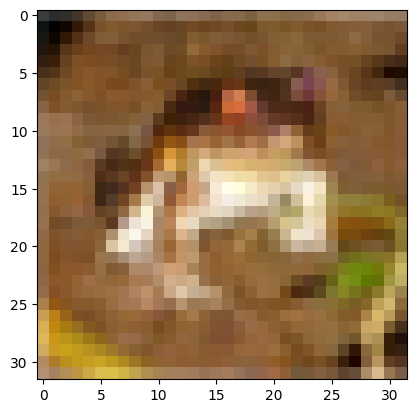

In [75]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

imshow(img_compare.detach().cpu())

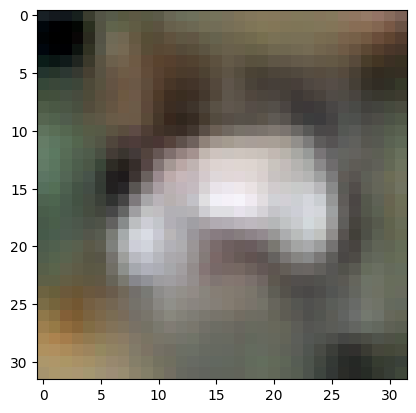

In [76]:
# picture from decrypt network
target = img_compare[None,:,:,:]
result = net_decoder(target)
imshow(result[0].detach().cpu())

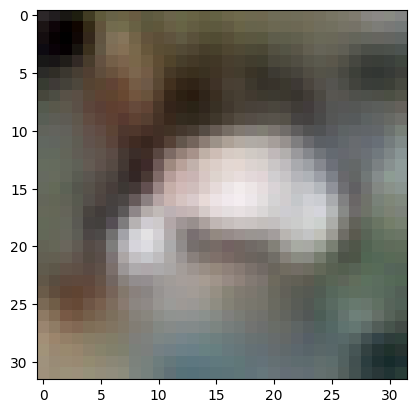

In [77]:
#picture from client weights
target = img_compare[None,:,:,:]
result = net_decoder.partial_eval((net.partial_eval(target)))
imshow(result[0].detach().cpu())

compare weights between two models

In [78]:
weight_diff = [(x - y).abs().sum() for x, y in zip(net.state_dict().values(), net_decrypt.state_dict().values())]

In [79]:
net.state_dict().keys()

odict_keys(['conv1.weight', 'conv1.bias', 'bn1.weight', 'bn1.bias', 'bn1.running_mean', 'bn1.running_var', 'bn1.num_batches_tracked', 'layer1.0.conv1.weight', 'layer1.0.conv1.bias', 'layer1.0.bn1.weight', 'layer1.0.bn1.bias', 'layer1.0.bn1.running_mean', 'layer1.0.bn1.running_var', 'layer1.0.bn1.num_batches_tracked', 'layer1.0.conv2.weight', 'layer1.0.conv2.bias', 'layer1.0.bn2.weight', 'layer1.0.bn2.bias', 'layer1.0.bn2.running_mean', 'layer1.0.bn2.running_var', 'layer1.0.bn2.num_batches_tracked', 'layer1.0.conv3.weight', 'layer1.0.conv3.bias', 'layer1.0.bn3.weight', 'layer1.0.bn3.bias', 'layer1.0.bn3.running_mean', 'layer1.0.bn3.running_var', 'layer1.0.bn3.num_batches_tracked', 'layer1.0.identity_downsample.0.weight', 'layer1.0.identity_downsample.0.bias', 'layer1.0.identity_downsample.1.weight', 'layer1.0.identity_downsample.1.bias', 'layer1.0.identity_downsample.1.running_mean', 'layer1.0.identity_downsample.1.running_var', 'layer1.0.identity_downsample.1.num_batches_tracked', 'lay

In [80]:
net_values = []
for n,_ in net.named_parameters():
  net_values.append(net.state_dict()[n])
net_decrypt_values = []
for n,_ in net_decrypt.named_parameters():
  net_decrypt_values.append(net_decrypt.state_dict()[n])

In [81]:
diff = [net_decrypt_values[i] - net_values[i] for i in range(len(net_values))]

In [82]:
cos = torch.nn.CosineSimilarity(dim=0).to(device)
i = 0
for n,_ in net_decrypt.named_parameters():
  output = cos(torch.flatten(net_values[i]), torch.flatten(net_decrypt_values[i]))
  print(n+'\t\t\t'+str(output.cpu().numpy()))
  i+=1

enc1.weight			-0.021821
enc1.bias			0.04650463
enc2.weight			0.9859871
enc2.bias			0.04069449
enc_layer1.0.conv1.weight			-0.021063916
enc_layer1.0.conv1.bias			0.058461882
enc_layer1.0.bn1.weight			1.0
enc_layer1.0.bn1.bias			0.0
enc_layer1.0.conv2.weight			0.0053389007
enc_layer1.0.conv2.bias			-0.00526125
enc_layer1.0.bn2.weight			0.99815977
enc_layer1.0.bn2.bias			0.07565639
enc_layer1.0.conv3.weight			0.0011551441
enc_layer1.0.conv3.bias			0.18940558
enc_layer1.0.bn3.weight			0.99532384
enc_layer1.0.bn3.bias			0.43112937
enc_layer1.0.identity_downsample.0.weight			0.017849948
enc_layer1.0.identity_downsample.0.bias			0.1148705
enc_layer1.0.identity_downsample.1.weight			0.99530756
enc_layer1.0.identity_downsample.1.bias			0.43112937
enc_layer1.1.conv1.weight			0.0045166565
enc_layer1.1.conv1.bias			0.18617943
enc_layer1.1.bn1.weight			1.0
enc_layer1.1.bn1.bias			0.0
enc_layer1.1.conv2.weight			0.017802592
enc_layer1.1.conv2.bias			0.14072579
enc_layer1.1.bn2.weight			0.9981791
enc

compare imtermediate images

In [83]:
corr = []

# since we're not training, we don't need to calculate the gradients for our outputs
cos = torch.nn.CosineSimilarity(dim=0).to(device)
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.cuda(), labels.cuda()
        '''
        # calculate outputs by running images through the network
        intermediate = net.partial_eval(images)
        print(intermediate.shape)
        sh = images[0,:,:,:].cpu().numpy()
        sh = sh/2+0.5
        plt.imshow(np.transpose(sh, (1,2,0)))
        plt.show()
        plt.imshow(intermediate[0,1,:,:].cpu().numpy())
        break
        outputs = net_decrypt.partial_out(intermediate)
        '''
        ori_inter = net.partial_eval(images)
        decrypt_inter = net_decrypt.partial_eval(images)
        corr.append(cos(torch.flatten(ori_inter),torch.flatten(decrypt_inter)))


print(corr[:10])

[tensor(0.8559, device='cuda:0'), tensor(0.8635, device='cuda:0'), tensor(0.8585, device='cuda:0'), tensor(0.8599, device='cuda:0'), tensor(0.8581, device='cuda:0'), tensor(0.8575, device='cuda:0'), tensor(0.8598, device='cuda:0'), tensor(0.8605, device='cuda:0'), tensor(0.8550, device='cuda:0'), tensor(0.8583, device='cuda:0')]


In [84]:
sum(corr)/len(corr)

tensor(0.8589, device='cuda:0')

## store data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp /content/LeNet.pth /content/drive/MyDrive/security_weight
!cp /content/LeNet_decrypt.pth /content/drive/MyDrive/security_weight
!cp /content/LeNet_pr.pth /content/drive/MyDrive/security_weight

### additional